In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [3]:
data = pd.read_csv('./assets/data.csv', index_col = 'Date')
data = data.iloc[:, :]
data

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_change,7ma,14ma,...,S&P500,Japan225,KoreanIndex,NASDQ,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-10,28.030001,28.240000,27.840000,27.990000,21.152483,48591300,-0.000714,-0.000714,28.146893,28.549826,...,1068.13,9963.99,1570.12,2147.87,154.354910,167.290639,174.546314,180.673782,172.971193,171.012076
2010-02-22,28.840000,28.940001,28.650000,28.730000,21.813244,36707100,-0.001390,-0.001391,28.574012,28.565252,...,1108.01,10400.47,1627.10,2242.03,153.927626,166.244162,172.853763,174.978117,155.958916,149.642177
2010-02-23,28.680000,28.830000,28.090000,28.330000,21.509542,52266200,-0.013923,-0.014021,28.513006,28.533674,...,1094.60,10352.10,1628.90,2213.44,153.499577,165.195810,171.157609,169.279583,139.178566,128.763209
2010-02-24,28.520000,28.790001,28.379999,28.629999,21.737309,43165900,0.010589,0.010534,28.542255,28.546592,...,1105.24,10198.83,1612.83,2235.90,153.070772,164.145658,169.458113,163.585385,122.804635,108.716028
2010-02-25,28.270000,28.650000,28.020000,28.600000,21.714539,48735300,-0.001048,-0.001048,28.556692,28.553749,...,1102.94,10101.96,1587.51,2234.22,152.641219,163.093779,167.755537,157.902711,107.004751,89.817016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,56.040001,56.189999,55.419998,55.480000,49.123569,27334100,-0.014740,-0.014850,55.803862,55.558860,...,2043.94,19033.71,1961.31,5007.41,52.327081,50.595761,50.780312,55.095542,54.143215,54.586299
2016-01-04,54.320000,54.799999,53.389999,54.799999,48.521469,53778000,-0.012257,-0.012332,55.552897,55.457678,...,2012.66,18450.98,1918.76,4903.09,52.367976,50.627803,50.825886,55.081878,54.036146,54.277425
2016-01-05,54.930000,55.389999,54.540001,55.049999,48.742832,34079700,0.004562,0.004552,55.427172,55.403321,...,2016.71,18374.00,1930.53,4891.43,52.408977,50.659860,50.871538,55.063044,53.929526,53.960263


In [4]:
data['y'] = data['Close']


# 检查并替换无穷大或过大的数值
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

x = data.iloc[:, :53].values
y = data.iloc[:, 53].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (1114, 53) trainY: (1114,)
testX: (279, 53) testY: (279,)


In [5]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [6]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([53, 400, 400, 400, 10], 10)

[1/300] Loss: 292.1860866546631
[2/300] Loss: 288.24646377563477
[3/300] Loss: 287.30249977111816
[4/300] Loss: 286.1381645202637
[5/300] Loss: 283.91312980651855
[6/300] Loss: 279.00783348083496
[7/300] Loss: 270.4492893218994
[8/300] Loss: 263.1234188079834
[9/300] Loss: 260.25440406799316
[10/300] Loss: 262.20422554016113
[11/300] Loss: 263.9275302886963
[12/300] Loss: 259.36837005615234
[13/300] Loss: 249.9628505706787
[14/300] Loss: 242.19174575805664
[15/300] Loss: 239.17077255249023
[16/300] Loss: 239.94272994995117
[17/300] Loss: 242.3154754638672
[18/300] Loss: 244.55409622192383
[19/300] Loss: 245.6700267791748
[20/300] Loss: 245.20846557617188
[21/300] Loss: 242.93402862548828
[22/300] Loss: 238.58011054992676
[23/300] Loss: 232.88216590881348
[24/300] Loss: 226.4873390197754
[25/300] Loss: 220.22311210632324
[26/300] Loss: 215.15946578979492
[27/300] Loss: 212.4370174407959
[28/300] Loss: 212.72504806518555
[29/300] Loss: 215.2263069152832
[30/300] Loss: 217.01674842834473


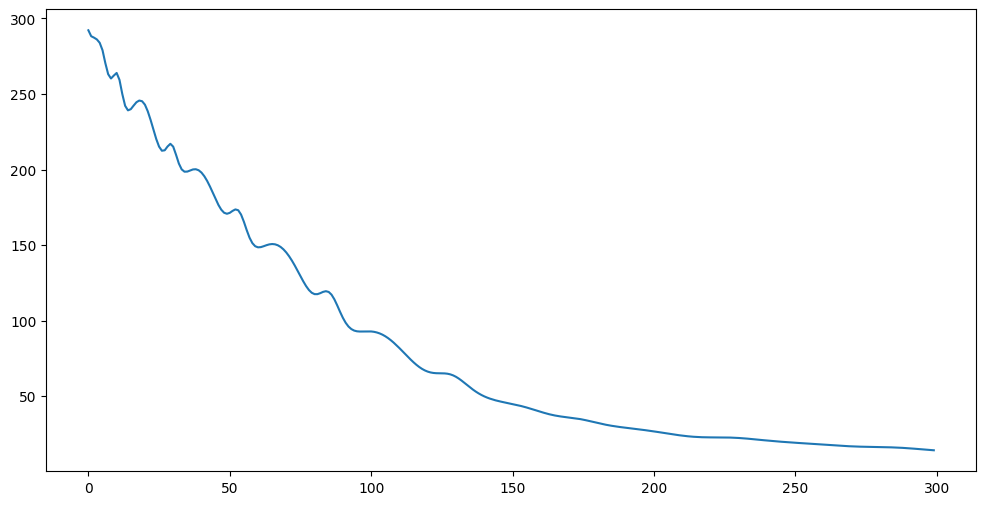

In [7]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [8]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [9]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [10]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [11]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1111, 3, 63]) train_y: torch.Size([1111, 1]) train_y_gan: torch.Size([1111, 4, 1])
test_x: torch.Size([276, 3, 63]) test_y: torch.Size([276, 1]) test_y_gan: torch.Size([276, 4, 1])


In [12]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

In [13]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)

model = Generator(63).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))



[1/300] Loss: 0.4683918559458107
[2/300] Loss: 0.4051733820233494
[3/300] Loss: 0.2648003257345408
[4/300] Loss: 0.08453092724084854
[5/300] Loss: 0.03786736470647156
[6/300] Loss: 0.0656760383863002
[7/300] Loss: 0.05529166525229812
[8/300] Loss: 0.0989695677999407
[9/300] Loss: 0.08647096762433648
[10/300] Loss: 0.16941591049544513
[11/300] Loss: 0.04111036722315475
[12/300] Loss: 0.0346848841290921
[13/300] Loss: 0.01697901135776192
[14/300] Loss: 0.014181457052472979
[15/300] Loss: 0.01443001558072865
[16/300] Loss: 0.013363770267460495
[17/300] Loss: 0.0140497355023399
[18/300] Loss: 0.013271412812173367
[19/300] Loss: 0.014647299016360193
[20/300] Loss: 0.016865944780874997
[21/300] Loss: 0.02466822718270123
[22/300] Loss: 0.05285493587143719
[23/300] Loss: 0.06936084269545972
[24/300] Loss: 0.20374558900948614
[25/300] Loss: 0.05719786987174302
[26/300] Loss: 0.07262673688819632
[27/300] Loss: 0.031016639666631818
[28/300] Loss: 0.028806406364310533
[29/300] Loss: 0.022839482931

Text(0.5, 0, 'Days')

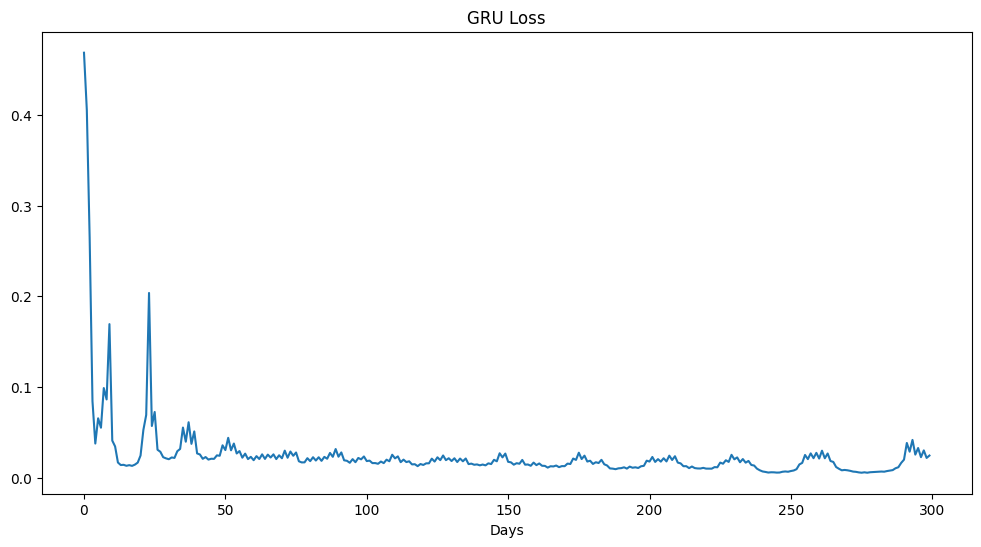

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('GRU Loss')
plt.xlabel('Days')


In [15]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.8071355075876085


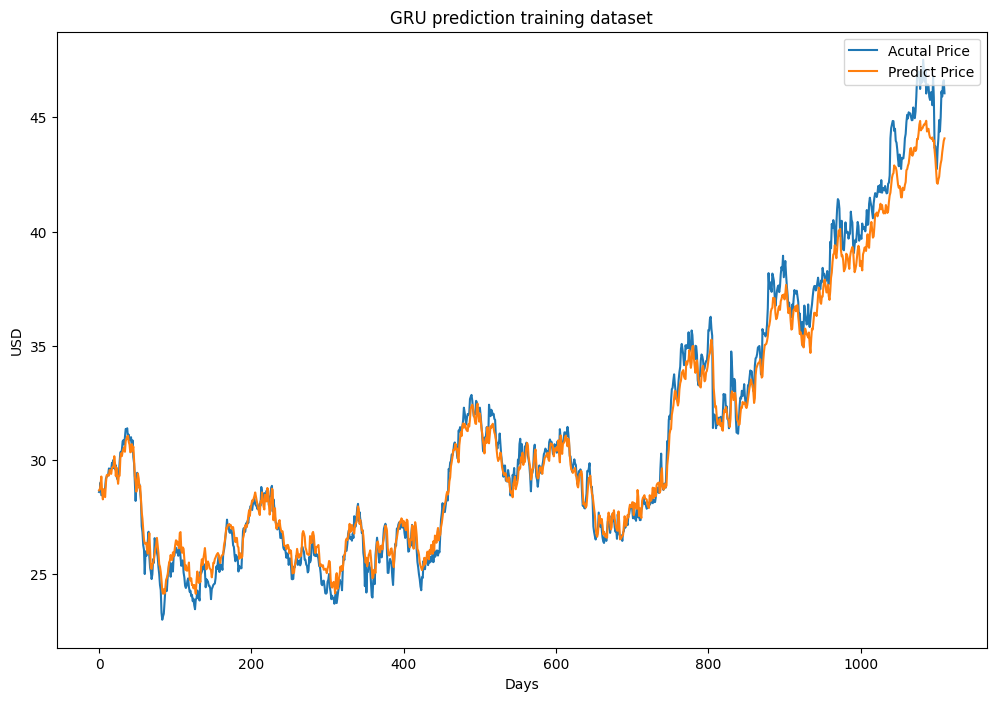

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true,  label = 'Acutal Price')
plt.plot(y_train_pred,  label = 'Predict Price')
plt.title('GRU prediction training dataset')
plt.ylabel('USD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:3.001030686566334


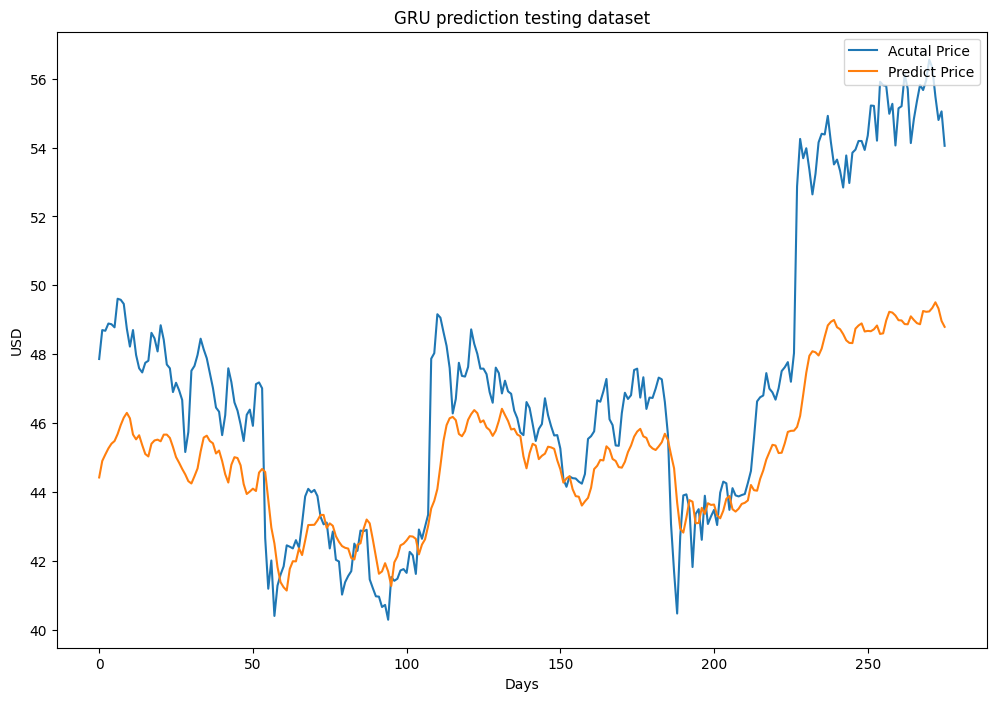

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true,  label = 'Acutal Price')
plt.plot(y_test_pred,  label = 'Predict Price')
plt.title('GRU prediction testing dataset')
plt.ylabel('USD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')